# Stock Market Series Analysis

Author: Caio Nunes

Contact: ccsn@ic.ufal.br

This notebook intends to make a study of Apple's Stock Market Data forecast problem.

## Importing packages

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import fbprophet as Prophet

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

## Loading the data

In [4]:
market_data = pd.read_csv('/media/caio/D9ED-4E70/TCC/AAPL.csv')
market_data['date'] = pd.to_datetime(market_data['date'])
market_data = market_data.set_index('date').sort_index()
#Freque 'B' for business days only
market_data = market_data.asfreq(freq='B')

market_data.tail()

volume        open       close        high         low  \
date                                                                     
2019-04-12  27760700.0  199.199997  198.869995  200.139999  196.210007   
2019-04-15  17536600.0  198.580002  199.229996  199.850006  198.009995   
2019-04-16  25696400.0  199.460007  199.250000  201.369995  198.559998   
2019-04-17  28906800.0  199.539993  203.130005  203.380005  198.610001   
2019-04-18  24195800.0  203.119995  203.860001  204.149994  202.520004   

              adjclose  
date                    
2019-04-12  198.869995  
2019-04-15  199.229996  
2019-04-16  199.250000  
2019-04-17  203.130005  
2019-04-18  203.860001

Because we made a change in frequency, now we have some Nan values to fill. We are going to fill the Nan values with the previous input, we are assuming that the stock price stayed the same.

In [5]:
market_data.isnull().values.any()

True

In [6]:
market_data.fillna(method='ffill', inplace = True)
market_data.isnull().values.any()

False

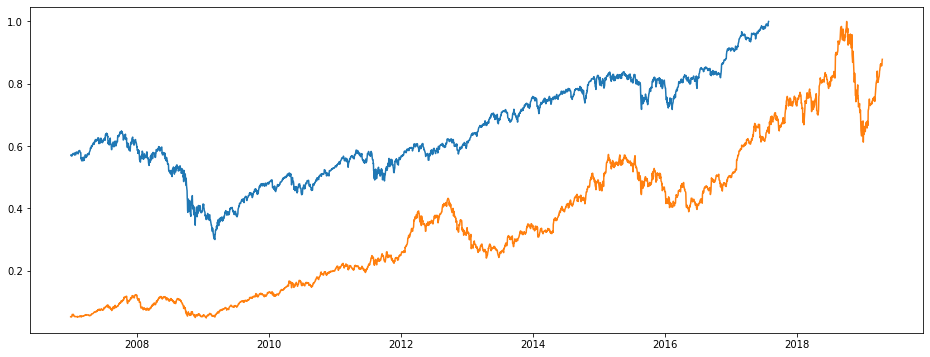

In [7]:
dji_data = pd.read_csv('/media/caio/D9ED-4E70/TCC/DJI.csv')
dji_data['Date'] = pd.to_datetime(dji_data['Date'])
dji_data = dji_data.set_index('Date')

plt.figure(figsize=(16, 6))

dji_close_norm = dji_data['Close']/(dji_data['Close'].max())
market_close_norm = market_data['close']/(market_data['close'].max())

plt.plot(dji_close_norm['01-01-2007':])
plt.plot(market_close_norm['01-01-2007':])

## Data Visualization

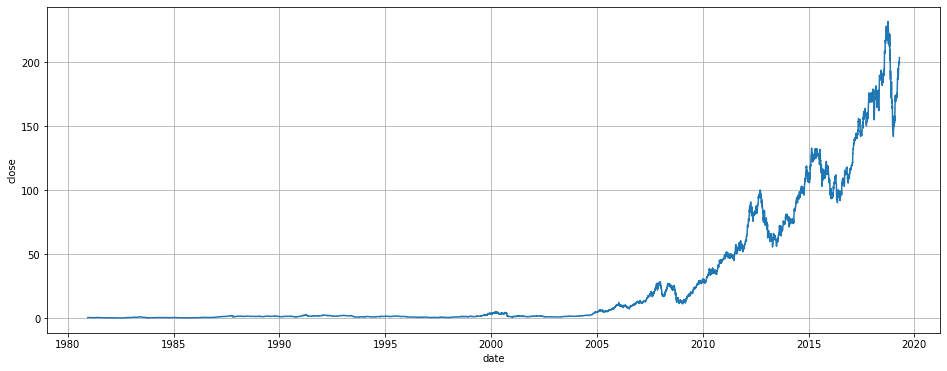

In [8]:
plt.figure(figsize=(16, 6))
plt.grid()

palette = sns.xkcd_palette(['dark green', 'dark blue', 'gold', 'orange'])

sns.lineplot(x = market_data.index, y = market_data['close'])

As we can see in the plot above, the stock market values were pretty unexpressive in the time before 2005, and started to grow at a huge rate after that. We probably wont use the data prior 2005 because it do not represent our series actual behavior.


### Close values / first difference

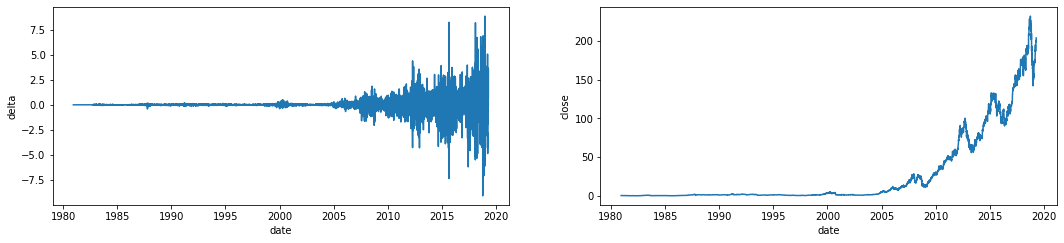

In [9]:
market_data['delta'] = market_data['close'] - market_data['open']

plt.figure(figsize=(18, 8))

plt.subplot(2,2,1)
sns.lineplot(x = market_data.index, y = market_data['delta'])
plt.subplot(2,2,2)
sns.lineplot(x = market_data.index, y = market_data['close'])


### Extracting seasonal components

In [10]:
components = seasonal_decompose(market_data.delta)

### Plotting autocorrelation

Here we use ACF to extract some information from our series.

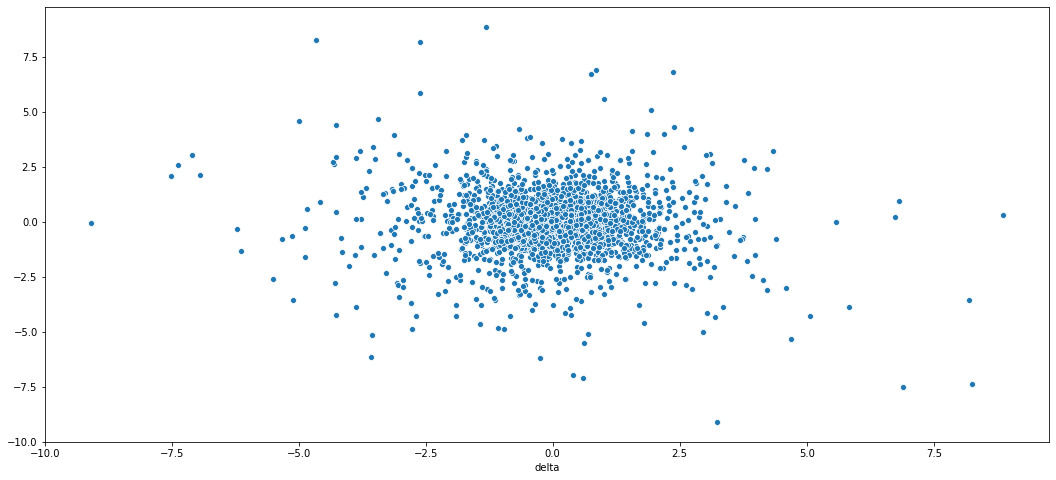

In [11]:
plt.figure(figsize=(18, 8))
sns.scatterplot(x= market_data.delta[:-1], y = market_data.delta.values[1:])

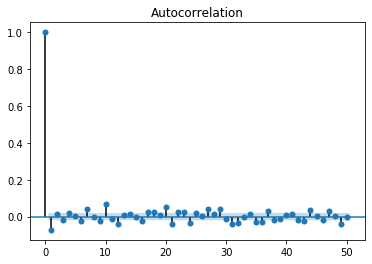

In [12]:
acf = plot_acf(market_data.delta, lags=50)

As we can see, there is no clear correlation between the variable and it's lagged value. 

## Getting new features

In this section we are going to extract some relavant features from our data.

In [13]:
window = 14

#Average True Range
true_range = []

for i in range(len(market_data)):
    x = []
    x.append(market_data.iloc[i]['high'] - market_data.iloc[i]['low'])
    x.append(abs(market_data.iloc[i]['high'] - market_data.iloc[i - 1]['close']))
    x.append(abs(market_data.iloc[i]['low'] - market_data.iloc[i - 1]['close']))
    true_range.append(max(x))
    
average_true_range = []
for i in range(len(market_data)):
    atr = np.mean(true_range[i - window : i+1])
    average_true_range.append(atr)

market_data['ATR'] = average_true_range

/home/caio/anaconda3/envs/ML/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning:

Mean of empty slice.

/home/caio/anaconda3/envs/ML/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



In [14]:
#MACD
def moving_average(data, window):
    MA = []
    for i in range(len(data)):
        MA.append(np.mean(data[i - window: i +1]))
    return MA

def exponencial_moving_average(data, window):
    weight = 2/(window + 1)
    EMA = []
    EMA.append(data.sum()/len(data))
    for i in range(1,len(data)):
        EMA.append(weight*(data[i]) + (1-weight)*(EMA[i-1]))
    return EMA

market_data['EMA_12'] = exponencial_moving_average(market_data['close'], 12)
market_data['EMA_26'] = exponencial_moving_average(market_data['close'], 26)

market_data['MACD'] = market_data['EMA_12'] - market_data['EMA_26']


In [15]:
#MFI

def raw_money_flow(data):
    RMF = []
    TYPICAL_PRICE = []
    for i in range(len(data)):
        entry = data.iloc[i]
        TYPICAL_PRICE.append((entry['high'] + entry['low'] + entry['close'])/3)
        
        if(TYPICAL_PRICE[i-1] > TYPICAL_PRICE[i]):
            TYPICAL_PRICE[i] *= -1

        RMF.append(TYPICAL_PRICE[i] * entry['volume'])
    return RMF
market_data['RMF'] = raw_money_flow(market_data)

def money_flow_index(data, window = 14):
    MFI = []
    for i in range(len(data)):
        positive_flow = 0
        negative_flow = 0
        for j in range(window):
            previous_entry = data.iloc[i - j]
            positive_flow += int(previous_entry['RMF'] > 0)*previous_entry['RMF']
            negative_flow -= int(previous_entry['RMF'] < 0)*previous_entry['RMF']
        money_flow_ratio = positive_flow/negative_flow
        MFI.append(100 - 100/(1 + money_flow_ratio))
    return MFI

market_data['MFI'] = money_flow_index(market_data)
       


/home/caio/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



In [16]:
#FastK and FastD

def FastK(data):
    FK = []
    [FK.append(0) for i in range(14)]
    for i in range(14,len(data)):
        L_14 = min(data['low'][i-14:i].values)
        H_14 = max(data['high'][i-14:i].values)
        FK.append((data['close'].iloc[i]-L_14)/(H_14-L_14)*100)
        
    return FK

def FastD(data):
    FD = []
    for i in range(len(data)):
        FD.append(data['FASTK'][i-3:i].mean())
    return FD
    

market_data['FASTK'] = FastK(market_data)
market_data['FASTD'] = FastD(market_data)

market_data.tail()

volume        open       close        high         low  \
date                                                                     
2019-04-12  27760700.0  199.199997  198.869995  200.139999  196.210007   
2019-04-15  17536600.0  198.580002  199.229996  199.850006  198.009995   
2019-04-16  25696400.0  199.460007  199.250000  201.369995  198.559998   
2019-04-17  28906800.0  199.539993  203.130005  203.380005  198.610001   
2019-04-18  24195800.0  203.119995  203.860001  204.149994  202.520004   

              adjclose     delta       ATR      EMA_12      EMA_26      MACD  \
date                                                                           
2019-04-12  198.869995 -0.330002  3.448000  196.104015  190.616360  5.487655   
2019-04-15  199.229996  0.649994  3.212002  196.584935  191.254407  5.330528   
2019-04-16  199.250000 -0.210007  2.846001  196.994945  191.846674  5.148272   
2019-04-17  203.130005  3.590012  2.950002  197.938801  192.682476  5.256325   
2019-04-18  203.860001  0.740005  2.923335  198.849754  193.510441  5.339314   

                     RMF        MFI       FASTK      FASTD  
date                                                        
2019-04-12 -5.507908e+09  73.063800   78.215599  87.261038  
2019-04-15  3.490309e+09  84.958081   80.186045  81.554408  
2019-04-16  5.132256e+09  84.845302   77.914077  79.018377  
2019-04-17  5.830694e+09  85.278518  101.827667  78.771907  
2019-04-18  4.924087e+09  85.378702  103.199972  86.642597

## Creating our model 

Now we are going to use those fresh created features to feed our regressive models.

First of all we need to split the between train and test sets. We are going to use 80% of our data on the training set and the rest (20%) on the test.

### Converting the data to supervisoned learn

In [147]:
features = ['close','volume', 'open', 'high', 'low', 'ATR', 'MACD', 'RMF', 'MFI', 'FASTK', 'FASTD']
TIME_STEPS = 10
SAMPLE_SIZE = 500

def build_timeseries(mat, y_col_index):
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0))
    
    for i in range(0, dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS + i, y_col_index]
    return x, y

x, y = build_timeseries(market_data[features].tail(SAMPLE_SIZE).values,0)

flat_x = np.array([x[i].flatten() for i in range(len(x))])

train_x, test_x = train_test_split(flat_x, train_size = .8, test_size = .2, shuffle = False)

train_y, test_y = train_test_split(y, train_size = .8, test_size = .2, shuffle = False)

### Random Forest

MSE: 2.497978154396524


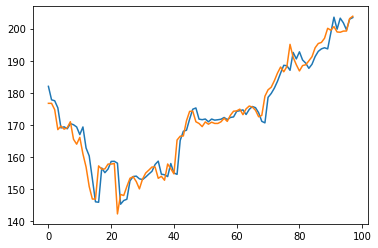

In [148]:
RF = RandomForestRegressor(n_estimators=100, n_jobs= 4)
RF.fit(train_x, train_y)
RF_prediction = RF.predict(test_x)
print("MSE: {}".format(mean_absolute_error(RF_prediction, test_y)))

plt.plot(RF_prediction)
plt.plot(test_y)
#sns.lineplot(x = test_x.index, y = test_y)